In [1]:
import pandas as pd
import numpy as np

import glob
from ase.io import read
from dscribe.descriptors import ACSF

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import pylab as pl


import random
import sys

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics

from pandas import set_option
pd.options.mode.chained_assignment = None

from sklearn import preprocessing
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [2]:
def ML_train(X_tr, y_tr, X_te, y_te):
    rstate = random.randrange(1,999999999,1)
    estimator = RandomForestRegressor(random_state = rstate, n_estimators = 10, n_jobs = 12)
    train = estimator.fit(X_tr, y_tr)
    pred = estimator.predict(X_te)
    
    # Cross validation 
    cvscore = cross_val_score(estimator, X_tr, y_tr, cv=5)
    score = cvscore.mean()
    print("Score with the entire dataset = %.2f" % score)
    
    print("Evaluate the error on the test data.")
    print("mean absolute error: ", mean_absolute_error(y_te, pred))
    print("mean squared error: ", mean_squared_error(y_te,pred))
    print("r2 score: ", r2_score(y_te, pred))
    return estimator

In [3]:
aN={1:'H',6:'C',7:'N',8:'O',20:'Ca'}

In [4]:
testsize = 0.3
rstate=random.randrange(1,999999999,1)



# Machine learning function
def RFR_atom(train_data, test_data):
    # to use the same random number in data shuffling for reproducible results
    # rstate = random.randrange(1,999999999,1)
    X_train = train_data[:,:-2]
    y_train = train_data[:,-1]
    
    X_test = test_data[:,:-2]
    y_test = test_data[:,-1]
    #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
    estimator = ML_train(X_train, y_train, X_test, y_test)
    return estimator

In [14]:
class Structure:
    
    def __init__(self, pdb_path):
        self.name = pdb_path.split('/')[1].split('.pdb')[0]
        self.water = int(self.name.split('.')[2][5:])
        self.system = self.name.split('.')[0]
        self.loop = self.name.split('.')[1]
        self.mdframe = self.name.split('.')[3]
        self.feat_atom=dict()
        #print("PDB name is ", self.name)
        
    def calc_sym(self):
        '''
        The function takes the structure file and compute the 
        symmetry function for each atom
        output: a list of symmetry functions for each atom. 
                Length of the list = number of atoms
            UPDATE: remove water molecules.
        ''' 
        pdb_file = self.name+'.pdb'
        chg_file = self.name + '.chg'
        structure = read("pdb/"+pdb_file)
        feat_lst=[]
        num=structure.get_global_number_of_atoms()
        atomPos = [x for x in range(0,num)]

        chg=np.genfromtxt("charge/"+chg_file)


        #for r_cut in [x/4. for x in range(4,13,1)]:
         
        # Setting up the ACSF descriptor
        for r_cut in [3., 4., 5., 6.]:
            acsf = ACSF(
                species=["C", "H", "O", "N", "Ca"],
                rcut=r_cut,
                g2_params=[[0.0001,0]],
            )
            feat_lst.append(acsf.create(structure,positions=atomPos,n_jobs=4))

        acsf_ang = ACSF(
            species=["C", "H", "O", "N", "Ca"],
            rcut=6.0,
            g4_params=[[0.0001,0.5,-1]],
        )
        feat_lst.append(acsf_ang.create(structure,positions=atomPos,n_jobs=4))

        feat = np.hstack(tuple(feat_lst))
        dat = np.hstack((feat,chg))
        np.savetxt('sym/sym_'+pdb_file[0:-4]+'.dat', dat, delimiter=',')
        
        # Skip water here
        # Skip to the last water x 3 rows
        skip_water = -3 * self.water
        # If there is no water, skip none (-1)
        if skip_water == 0:
            skip_water = None
        #print("skip water atoms",skip_water)
        #print(dat.shape)
        #print(dat[:skip_water,:].shape)
        for i in dat[:skip_water,:]:
            ikey = aN[int(i[-2])]
            if ikey in self.feat_atom:
                self.feat_atom[ikey] = np.vstack((self.feat_atom[ikey],i))
            else:
                #print(ikey,"is not in the dictionary, adding ...")
                self.feat_atom[ikey] = i

In [15]:

# Use all the files
loops = glob.glob("pdb/*.pdb")
structures = dict()
counter = 0
count_total = len(loops)
for loop in loops:
    name = loop.split('/')[1].split('.pdb')[0]
    structures[name]=Structure(loop)
    structures[name].calc_sym()  

    counter = counter + 1
    if counter % 100 == 0:
        #sys.stdout.write('\r')
        print(counter, "structures out of ", count_total, " processed ...", end = '\r')
        sys.stdout.flush()

In [16]:
# Split the data into train and data
name=np.array([i for i in structures.keys()])
struct_Train, struct_Test = train_test_split(name, test_size = testsize, random_state = rstate)

In [18]:
# Put data in the train, test dicts.
# Data sorted as for elements
# TODO: Need to exclude water molecules from the list
# because charges for the water molecules are fixed.
Train_Data_atom = dict()
for loop_name in struct_Train:
    #print(loop_name)
    for ele in aN.values():
        if ele in Train_Data_atom:
            Train_Data_atom[ele] = np.vstack((Train_Data_atom[ele],structures[loop_name].feat_atom[ele]))
        else:
            Train_Data_atom[ele] = structures[loop_name].feat_atom[ele]

Test_Data_atom = dict()
for loop_name in struct_Test:
    for ele in aN.values():
        if ele in Test_Data_atom:
            Test_Data_atom[ele] = np.vstack((Test_Data_atom[ele],structures[loop_name].feat_atom[ele]))
        else:
            Test_Data_atom[ele] = structures[loop_name].feat_atom[ele]


In [19]:
Train_Data_atom['H'].shape

(446293, 32)

In [21]:
# ML models for each element out of 70% of the data
estimator=dict()
for ele in Train_Data_atom:
    print("Training for atoms according to the element: ", ele)
    estimator[ele] = RFR_atom(Train_Data_atom[ele], Test_Data_atom[ele])
    print("\n")

Training for atoms according to the element:  H
Score with the entire dataset = 0.59
Evaluate the error on the test data.
mean absolute error:  0.06586769704342088
mean squared error:  0.010132407814608904
r2 score:  0.5913356896026405


Training for atoms according to the element:  C
Score with the entire dataset = 0.70
Evaluate the error on the test data.
mean absolute error:  0.2075039598888497
mean squared error:  0.07986728420759517
r2 score:  0.6989328412538635


Training for atoms according to the element:  N
Score with the entire dataset = 0.47
Evaluate the error on the test data.
mean absolute error:  0.21266378226656402
mean squared error:  0.08242669051497567
r2 score:  0.4689502366733329


Training for atoms according to the element:  O
Score with the entire dataset = 0.55
Evaluate the error on the test data.
mean absolute error:  0.06986675252247357
mean squared error:  0.010431032287312353
r2 score:  0.5536339908463227


Training for atoms according to the element:  Ca
Sc

In [22]:
class MLPlot:
    
    # Edit the font, font size, and axes width
    mpl.rcParams['font.family'] = 'Times New Roman'
    plt.rcParams['font.size'] = 24
    plt.rcParams['axes.linewidth'] = 3
    
    def __init__(self, MLdata, MLestimator):
        X = MLdata[:,:-2]
        y = MLdata[:,-1]
        #X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testsize, random_state = rstate)
        #self.qm = y_test
        #self.ml = MLestimator.predict(X_test)
        self.qm = y
        self.ml = MLestimator.predict(X)
        
    # Plot outputs
    def corrplot(self):
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot()

        plt.plot(self.qm, self.ml,'ro',fillstyle='none')
        
        # determine the range
        qm_max=np.max(self.qm)
        qm_min=np.min(self.qm)
        ml_max=np.max(self.ml)
        ml_min=np.min(self.ml)
        sigma=np.std(self.qm)+np.std(self.ml)
        ax_low=min(qm_min,ml_min)-sigma
        ax_up=max(qm_max,ml_max)+sigma
        
        plt.xlim(ax_low,ax_up)
        plt.ylim(ax_low,ax_up)
        plt.plot([ax_low,ax_up],[ax_low,ax_up], '--b')

        plt.xlabel('QM i-RESP charge (e)')
        plt.ylabel('ML charge (e)')
        
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')


        #ax.xaxis.grid(True, which='minor')
        # square figure
        ax.set_aspect('equal', adjustable='box')
        plt.show()
    
    
    def cmplot(self):
        fig = plt.figure(figsize=(10,10))
        ax = fig.add_subplot()
        skip = int(len(self.qm)/1000)
        plt.plot(self.qm[::skip], color='red', marker='o', linewidth=1, label = 'QM i-RESP charge (e)')
        plt.plot(self.ml[::skip], color='blue', marker='o', linewidth=1, label = 'ML charge (e)')
        plt.legend(loc='best')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='both', which='major', direction='in', length=14, width=4, color='k')
        ax.tick_params(axis='both', which='minor', direction='in', length=8, width=2, color='k')
        
        plt.xlabel('Index')
        plt.ylabel('Atomic charge (e)')
        plt.show()

In [23]:
# Chopping the data for validation
if False:
    X_train_total_size = X_train.shape[0]
    chunk = 1
    chunk_size = int(X_train_total_size / chunk)
    for i in range(chunk):
        row = 1 + i*chunk_size + chunk_size
        sub_X_train = X_train[0:row,:]
        sub_y_train = y_train[0:row]
        ML_train(sub_X_train,sub_y_train,X_test,y_test)

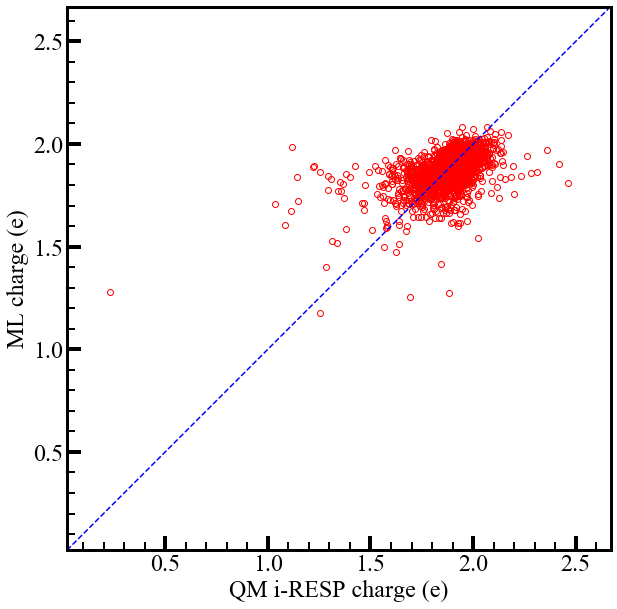

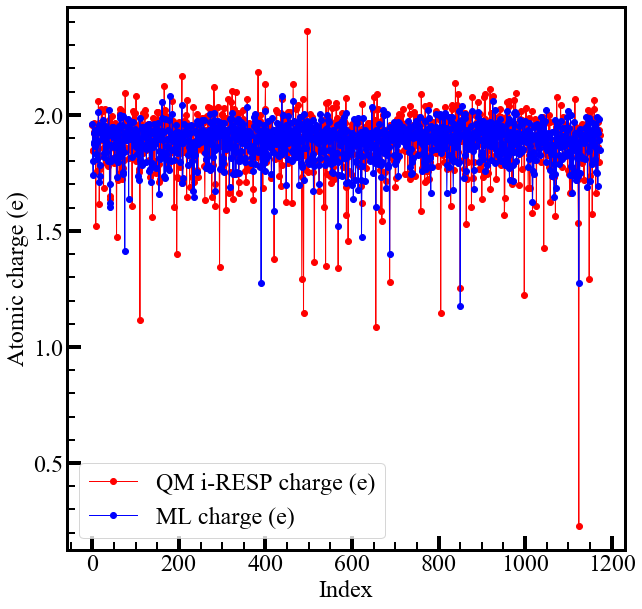

In [25]:
Caplot = MLPlot(Test_Data_atom['Ca'], estimator['Ca'])
Caplot.corrplot()
Caplot.cmplot()

In [27]:
# Now investigate what happens to structures with large number of water molecules
# First collecting the structures.

Data_atom_sub = dict()
for loop_name in struct_Test:
    struct = structures[loop_name]
    for ele in struct.feat_atom:
        tup_key = (ele, struct.water)
        if tup_key in Data_atom_sub:
            Data_atom_sub[tup_key] = np.vstack((Data_atom_sub[tup_key], struct.feat_atom[ele]))
        else:
            Data_atom_sub[tup_key] = struct.feat_atom[ele]

In [28]:
for group in Data_atom_sub:
    print("\nchecking group of structures with", group[1], "for", group[0], "atoms")
    MLdata = Data_atom_sub[group]
    MLestimator = estimator[group[0]]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))



checking group of structures with 3 for C atoms
Evaluate the error.
mean absolute error:  0.209986675364748
mean squared error:  0.08171493340627335
r2 score:  0.7018250976883217

checking group of structures with 3 for O atoms
Evaluate the error.
mean absolute error:  0.07223674359048829
mean squared error:  0.01119685568916813
r2 score:  0.5270481791508985

checking group of structures with 3 for H atoms
Evaluate the error.
mean absolute error:  0.06662187473733724
mean squared error:  0.010019934197608235
r2 score:  0.6066210963948826

checking group of structures with 3 for N atoms
Evaluate the error.
mean absolute error:  0.2174895189026616
mean squared error:  0.08682673766341488
r2 score:  0.4481227200203979

checking group of structures with 3 for Ca atoms
Evaluate the error.
mean absolute error:  0.06647199509189641
mean squared error:  0.008119316424544337
r2 score:  0.24349187535019268

checking group of structures with 4 for C atoms
Evaluate the error.
mean absolute error:

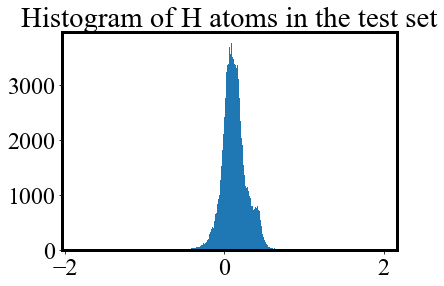

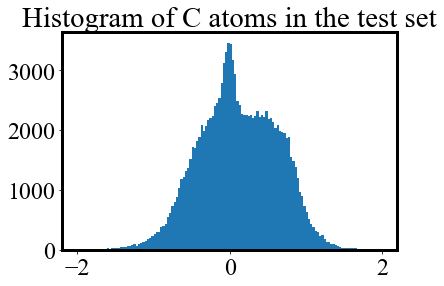

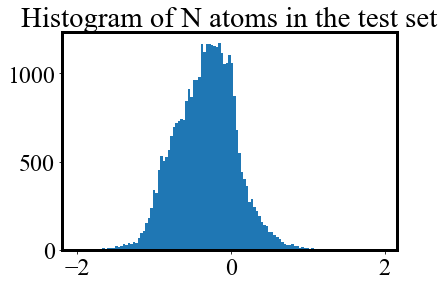

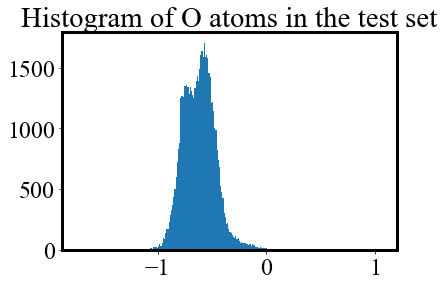

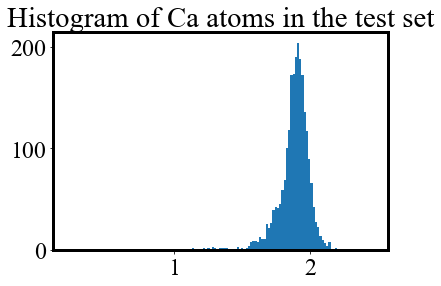

In [29]:
# Evaluate distribution of the QM charges in the test set
for ele, feat in Test_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the test set")
    plt.show()

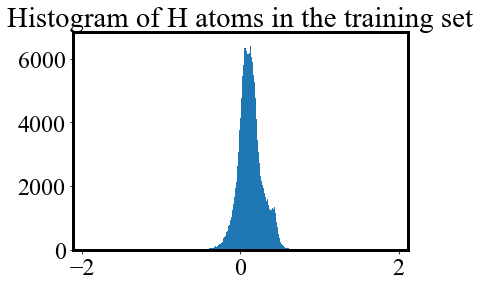

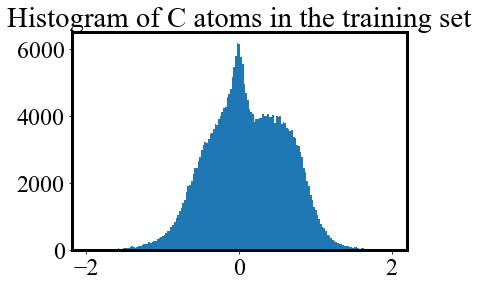

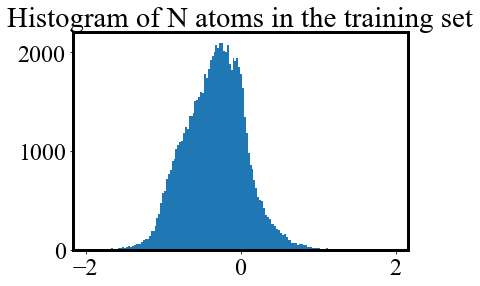

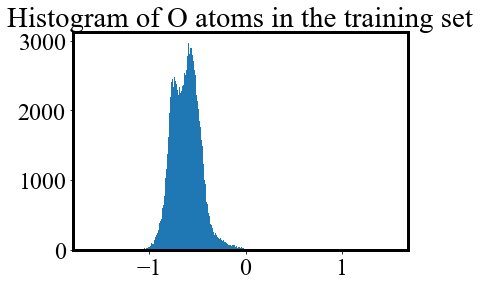

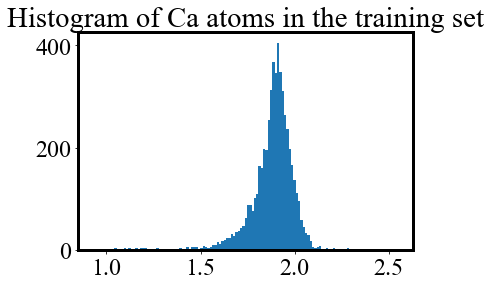

In [30]:
# Evaluate distribution of the QM charges in the training set
for ele, feat in Train_Data_atom.items():
    _ = plt.hist(feat[:,-1], bins='auto')
    plt.title("Histogram of " + ele + " atoms in the training set")
    plt.show()

In [31]:
# Evaluate distribution of the QM charges in the test set
# According to number of waters
    
water012 = dict()
water3_8 = dict()

for loop_name in struct_Test:
    feat = structures[loop_name].feat_atom
    if structures[loop_name].water < 3:
        for item in feat:
            if item not in water012:
                water012[item] = feat[item]
            else:
                water012[item] = np.vstack((water012[item], feat[item]))
    else:
        for item in feat:
            if item not in water3_8:
                water3_8[item] = feat[item]
            else:
                water3_8[item] = np.vstack((water3_8[item], feat[item]))



In [32]:
for ele in water012:
    print("\nchecking group of structures with <3 water molecules for", ele, "atoms")
    MLdata = water012[ele]
    MLestimator = estimator[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))



checking group of structures with <3 water molecules for C atoms
Evaluate the error.
mean absolute error:  0.20128964999301646
mean squared error:  0.07350005024556765
r2 score:  0.7113557867035576

checking group of structures with <3 water molecules for O atoms
Evaluate the error.
mean absolute error:  0.06824339047881614
mean squared error:  0.009482382437426782
r2 score:  0.590368420837885

checking group of structures with <3 water molecules for H atoms
Evaluate the error.
mean absolute error:  0.06565854399557541
mean squared error:  0.010705792050368798
r2 score:  0.5826366897653196

checking group of structures with <3 water molecules for N atoms
Evaluate the error.
mean absolute error:  0.20351444128957363
mean squared error:  0.0751953242630034
r2 score:  0.5196715311886668

checking group of structures with <3 water molecules for Ca atoms
Evaluate the error.
mean absolute error:  0.05046487584226473
mean squared error:  0.0045661616242154476
r2 score:  0.18931567591967602


In [33]:
for ele in water3_8:
    print("\nchecking group of structures with >= 3 water molecules for", ele, "atoms")
    MLdata = water3_8[ele]
    MLestimator = estimator[ele]
    X = MLdata[:,:-2]
    y = MLdata[:,-1]
    pred = MLestimator.predict(X)
    print("Evaluate the error.")
    print("mean absolute error: ", mean_absolute_error(y, pred))
    print("mean squared error: ", mean_squared_error(y,pred))
    print("r2 score: ", r2_score(y, pred))



checking group of structures with >= 3 water molecules for C atoms
Evaluate the error.
mean absolute error:  0.21251666809337738
mean squared error:  0.0850033470137006
r2 score:  0.6892668541767457

checking group of structures with >= 3 water molecules for O atoms
Evaluate the error.
mean absolute error:  0.07116924258227818
mean squared error:  0.011192173035020897
r2 score:  0.5214651298568209

checking group of structures with >= 3 water molecules for H atoms
Evaluate the error.
mean absolute error:  0.06603962112410611
mean squared error:  0.009661085217936675
r2 score:  0.5983486755316301

checking group of structures with >= 3 water molecules for N atoms
Evaluate the error.
mean absolute error:  0.22010717540666577
mean squared error:  0.08830972647230417
r2 score:  0.40157764727068224

checking group of structures with >= 3 water molecules for Ca atoms
Evaluate the error.
mean absolute error:  0.08791346027449391
mean squared error:  0.017856630612378063
r2 score:  0.17395005

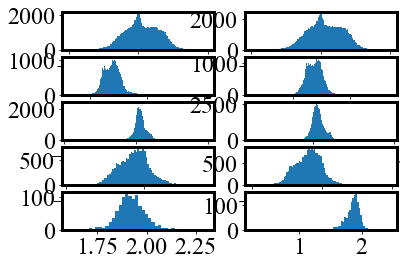

In [34]:
plt.figure#(figsize=(5, 10))
fig, axs = plt.subplots(5,2)
cnt = 0
for ele in water012:
    chg = water012[ele][:,-1]
    axs[cnt,0].hist(chg, bins='auto')
#    axs[cnt,0].title("Histogram of " + ele + " atoms with <3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()

cnt = 0
for ele in water3_8:
    chg = water3_8[ele][:,-1]
    axs[cnt,1].hist(chg, bins='auto')
 #   axs[cnt,1].title("Histogram of " + ele + " atoms with >=3 H2O in the test set")
    cnt = cnt + 1
#    plt.show()